In [1]:
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import signal
from scipy.integrate import quad
from scipy import integrate
from scipy import signal
import cmath
from numpy.random import normal
from itertools import accumulate as acc

def read_ltspice_ac(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        z = []
        next(data) # skip header line
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            complex = p[1].split(",")
            y.append(float(complex[0]))
            z.append(float(complex[1]))

    return x, y, z
    
def SK_lowpass(Q, cn, fc, n, C, K):
   
    d = (n*(1-K)+1)
    a = d**2*Q**2
    b = 2*Q**2*d-n
    c = a
    
    m_a = (-b+np.sqrt(b**2-4*a*c))/2/a
    m_b = (-b-np.sqrt(b**2-4*a*c))/2/a
    
    C1 = C
    C2 = n*C1
    R2 =1/fc/2/np.pi/C1/np.sqrt(m_b*n)/cn
    R1 = R2*m_b

    return C1, C2, R1, R2
    
def SK_highpass(Q, cn, fc, m, R, K):
   
    d = (m*(1-K)+1)
    a = d**2*Q**2
    b = 2*Q**2*d-m
    c = a
    
    n_a = (-b+np.sqrt(b**2-4*a*c))/2/a
    n_b = (-b-np.sqrt(b**2-4*a*c))/2/a
    
    R1 = R
    R2 = R1/m
    C2 =1/fc/2/np.pi/R2/np.sqrt(n_b*m)/cn
    C1 = C2*n_b

    return C1, C2, R1, R2

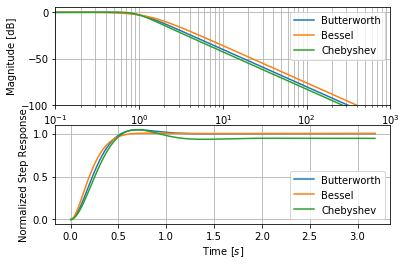

In [2]:
""" Compare the frequency and step responses of
    Butterworth, Bessel, and Chebyshev Filters """

order = 2
fc = 1

# 2nd Order Butterworth 
b, a = signal.butter(order, 2*np.pi*fc, 'low', analog=True)
butter_2 = signal.TransferFunction(b, a)
f = np.logspace(fc - 2, fc + 4, 1000)
w = 2*np.pi*f
w, mag_butter, phase_butter = butter_2.bode(w)

# 2nd Order Chebyshev
cheby_scaling = 1.38974
b, a = signal.cheby1(order, .5, 2*np.pi*fc/cheby_scaling, 'low', analog=True)
cheby_2 = signal.TransferFunction(b, a)
w, mag_cheby, phase_cheby = cheby_2.bode(w)

# 2nd Order Bessel
b, a = signal.bessel(order, 2*np.pi*fc*1.272, 'low', analog=True)
bessel_2 = signal.TransferFunction(b, a)
w, mag_bessel, phase_bessel = bessel_2.bode(w)

f = w/2/np.pi

# Magnitude and step response comparison
fig, ax = plt.subplots(2)

ax[0].semilogx(f, mag_butter)
ax[0].semilogx(f, mag_bessel)
ax[0].semilogx(f, mag_cheby)
ax[0].grid(which='both', axis='both')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Magnitude [dB]')
ax[0].set_ylim(-100, 6)
ax[0].set_xlim(10**(fc-2), 10**(fc+4/order))
ax[0].legend( ['Butterworth', 'Bessel', 'Chebyshev'])

tin = np.linspace(0, 20/fc/2/np.pi, 1000)
tout1, step_butter = signal.step(butter_2, X0=None, T=tin)
tout2, step_bessel= signal.step(bessel_2, X0=None, T=tin)
tout3, step_cheby = signal.step(cheby_2, X0=None, T=tin)

ax[1].plot(tout1, step_butter)
ax[1].plot(tout2, step_bessel)
ax[1].plot(tout3, step_cheby)
ax[1].grid()

ax[1].set_xlabel(r'Time $[s]$')
ax[1].set_ylabel('Normalized Step Response')
ax[1].legend( ['Butterworth', 'Bessel', 'Chebyshev'])

3.3 0.3297909021489386 3.3e-08 1e-08 9518.211224417571 28861.351730433737
50.6944 1 5.06944e-07 1e-08 2250.6264946000124 2250.6264946000124


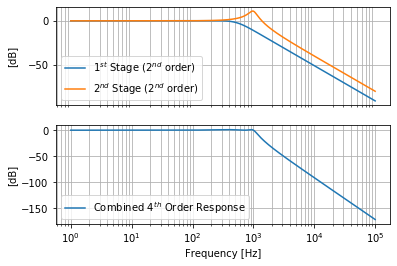

In [3]:
""" 4th Order Lowpass Chebyshev """

# First stage design
Q1 = 0.7845
cn1 = 0.5286
fc1 = 1e3 

n1 = 3.3 
a1 = Q1**2
b1 = 2*Q1**2-n1
c1 = Q1**2
m1_a = (-b1+np.sqrt(b1**2-4*a1*c1))/2/a1
m1_b = (-b1-np.sqrt(b1**2-4*a1*c1))/2/a1

C1 = 0.01e-6
C2 = n1*C1
R2 = 1/fc1/2/np.pi/C1/np.sqrt(m1_b*n1)/cn1
R1 = R2*m1_b

print(n1, m1_b, C2, C1, R1, R2)

w01 = 2*np.pi*fc1*cn1


# Second stage design
Q2 = 3.56
cn2 = 0.9932
fc2 = 1e3 

m2 = 1   
n2 = Q2**2*(1+m2)**2/m2

C3 = 0.01e-6
C4 = n2*C3
R4 = 1/fc2/2/np.pi/C3/np.sqrt(m2*n2)/cn2
R3 = R4*m2

print(n2, m2, C4, C3, R3, R4)
 
w02 = 2*np.pi*fc2*cn2

# Plot the transfer functions

a1 = 1
b1 = w01/Q1
c1 = w01**2
num1 = [c1]
den1 = [a1, b1, c1]

a2 = 1
b2 = w02/Q2
c2 = w02**2
num2 = [c2]
den2 = [a2, b2, c2]

stage1 = signal.TransferFunction(num1, den1)
stage2 = signal.TransferFunction(num2, den2)
cheby_4th = signal.TransferFunction(np.polymul(num1, num2), np.polymul(den1, den2))

f = np.logspace(0, 5, 1000)
w = 2*np.pi*f
w1, mag1, phase1 = stage1.bode(w=w)
w2, mag2, phase2 = stage2.bode(w=w)
w3, mag4, phase4 = cheby_4th.bode(w=w)

fig, ax = plt.subplots(2)
ax[0].semilogx(f, mag1)
ax[0].semilogx(f, mag2)
ax[0].grid(which='both', axis='both')
ax[0].axes.xaxis.set_ticks([])
ax[0].axes.xaxis.set_ticklabels([])
ax[0].set_ylabel('[dB]')

ax[1].semilogx(f, mag4)
ax[1].grid(which='both', axis='both')
ax[1].set_ylabel('[dB]')
ax[1].set_xlabel('Frequency [Hz]')
fig.align_ylabels(ax[:])

ax[0].legend( [r'$1^{st}$ Stage ($2^{nd}$ order)', r'$2^{nd}$ Stage ($2^{nd}$ order)'])
ax[1].legend( [r'Combined $4^{th}$ Order Response', r'$2^{nd}$ Stage ($2^{nd}$ order)'])


plt.show()

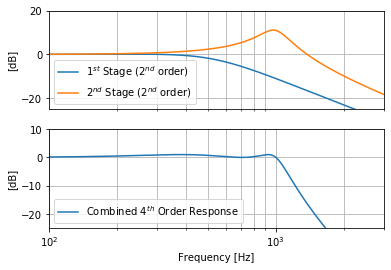

In [4]:
#Closer look at the responses

fig, ax = plt.subplots(2)
ax[0].semilogx(f, mag1)
ax[0].semilogx(f, mag2)
ax[0].grid(which='both', axis='both')
ax[0].axes.xaxis.set_ticks([])
ax[0].axes.xaxis.set_ticklabels([])
ax[0].set_ylabel('[dB]')
ax[0].set_ylim(-25,20)
ax[0].set_xlim(100, 3e3)

ax[1].semilogx(f, mag4)
ax[1].grid(which='both', axis='both')
ax[1].set_ylabel('[dB]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylim(-25,10)
ax[1].set_xlim(100, 3e3)
fig.align_ylabels(ax[:])

ax[0].legend( [r'$1^{st}$ Stage ($2^{nd}$ order)', r'$2^{nd}$ Stage ($2^{nd}$ order)'])
ax[1].legend( [r'Combined $4^{th}$ Order Response', r'$2^{nd}$ Stage ($2^{nd}$ order)'])

plt.show()

""" Comparison with SPICE simulation result """

freqs, reals, imags = read_ltspice_ac('chebyshev_4th.txt')
mags = np.sqrt(np.asarray(reals)**2 + np.asarray(imags)**2)

fig, ax = plt.subplots()
ax.semilogx(freqs, 20*np.log10(mags))
ax.semilogx(f, mag4)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.grid(which='both',axis='both')
ax.legend( [r'SPICE Result', r'Transfer Function Model'])
plt.show()

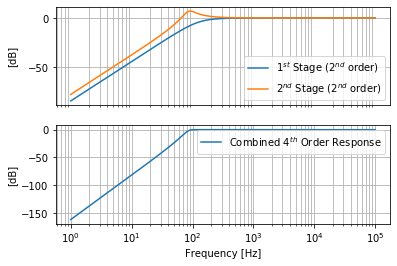

In [5]:
""" 0.1dB Ripple 4th Order Chebyshev """
f_ratio = 1.213 # taken from Table 1 in MT-206 app note
fc_hp = 100/f_ratio

Q1 = 0.6188
cn1 = 0.6506
w01 = 2*np.pi*fc_hp/cn1
Q2 = 2.1834
cn2 = 0.9507
w02 = 2*np.pi*fc_hp/cn2

a1 = 1
b1 = w01/Q1
c1 = w01**2
num1 = [1, 0, 0]
den1 = [a1, b1, c1]

a2 = 1
b2 = w02/Q2
c2 = w02**2
num2 = [1, 0, 0]
den2 = [a2, b2, c2]

stage1 = signal.TransferFunction(num1, den1)
stage2 = signal.TransferFunction(num2, den2)
cheby_4th = signal.TransferFunction(np.polymul(num1, num2), np.polymul(den1, den2))

f = np.logspace(0, 5, 1000)
w = 2*np.pi*f
w1, mag1, phase1 = stage1.bode(w=w)
w2, mag2, phase2 = stage2.bode(w=w)
w3, mag4, phase4 = cheby_4th.bode(w=w)

fig, ax = plt.subplots(2)
ax[0].semilogx(f, mag1)
ax[0].semilogx(f, mag2)
ax[0].grid(which='both', axis='both')
ax[0].axes.xaxis.set_ticks([])
ax[0].axes.xaxis.set_ticklabels([])
ax[0].set_ylabel('[dB]')
#ax[0].set_xlim(10, 1e3)
#ax[0].set_ylim(-10, 10)

ax[1].semilogx(f, mag4)
ax[1].grid(which='both', axis='both')
ax[1].set_ylabel('[dB]')
ax[1].set_xlabel('Frequency [Hz]')
#ax[1].set_ylim(-2, 2)
#ax[1].set_xlim(10, 1e3)
fig.align_ylabels(ax[:])

ax[0].legend( [r'$1^{st}$ Stage ($2^{nd}$ order)', r'$2^{nd}$ Stage ($2^{nd}$ order)'])
ax[1].legend( [r'Combined $4^{th}$ Order Response', r'$2^{nd}$ Stage ($2^{nd}$ order)'])


plt.show()

8.095070667207005e-09 1.9488092779496023e-07 100000.0 10000.0
6.592337830332881e-08 1.0219729324940999e-07 100000.0 5000.0
1.1881115310664143e-06 2.1319796372861313e-05 100000.0 10000.0
1e-08 3.3e-08 4190.455732483218 18317.452171444438


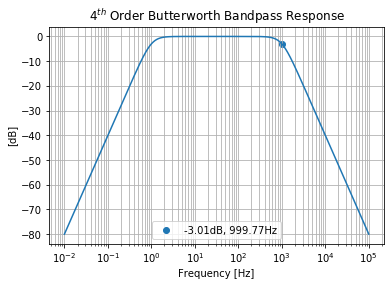

In [6]:
# Calculate component values
C1, C2, R1, R2 = SK_highpass(Q1, 1/cn1, fc_hp, 10, 100e3, 1)
print(C1, C2, R1, R2)
C3, C4, R3, R4 = SK_highpass(Q2, 1/cn2, fc_hp, 20, 100e3, 1)
print(C3, C4, R3, R4)


""" 4th Order Bandpass Filter """
Q_lp = 1/np.sqrt(2)
Q_hp = Q_lp
fc_hp = 1
fc_lp = 1e3
w0_hp = np.pi*2*fc_hp
w0_lp = np.pi*2*fc_lp

C1, C2, R1, R2 = SK_highpass(Q_hp, 1, fc_hp, 10, 100e3, 1)
print(C1, C2, R1, R2)
C3, C4, R3, R4 = SK_lowpass(Q_lp, 1, fc_lp, 3.3, 10e-9, 1)
print(C3, C4, R3, R4)

a1 = 1
b1 = w0_hp/Q_hp
c1 = w0_hp**2
num1 = [1, 0, 0]
den1 = [a1, b1, c1]

a2 = 1
b2 = w0_lp/Q_lp
c2 = w0_lp**2
num2 = [c2]
den2 = [a2, b2, c2]

butter_bp_4th = signal.TransferFunction(np.polymul(num1, num2), np.polymul(den1, den2))

f = np.logspace(-2, 5, 10000)
w = 2*np.pi*f
w_bp, mag_bp, phase_bp = butter_bp_4th.bode(w=w)

fig, ax = plt.subplots()
x1 = 4000+np.where(mag_bp[4000:]<=-3)[0][0]
label1 = "{:.2f}dB, {:.2f}Hz".format(mag_bp[x1],f[x1])
ax.semilogx(f, mag_bp)
ax.scatter(f[x1],mag_bp[x1],label=label1,color='tab:blue')
ax.grid(which='both', axis='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('[dB]')
#ax.set_xlim(10, 1e3)
#ax.set_ylim(-10, 10)
ax.set_title(r'$4^{th}$ Order Butterworth Bandpass Response')
ax.legend()

plt.show()